In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend
import numpy as np


# def init_session():
#     tf_config = tf.ConfigProto()
#     tf_config.allow_soft_placement = True
#     tf_config.gpu_options.allow_growth = True
#     tf_config.gpu_options.visible_device_list = str(0)
#     sess=tf.Session(config=tf_config)

#     keras.backend.set_session(sess)

# init_session()

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
train_raw=pd.read_pickle("train.pkl")
train_raw.head(10)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
key,,,,,,,
9031622,8.500000,2015-01-17 18:59:00,-73.987869,40.765583,-73.974632,40.783310,1
22554761,22.500000,2012-04-14 17:31:00,-73.989304,40.726315,-73.921013,40.657829,1
12970081,4.900000,2011-03-01 07:19:00,-73.995384,40.733250,-73.990784,40.745449,1
28899305,34.330002,2013-10-30 20:05:00,-73.872513,40.774143,-73.978508,40.766727,1
2065870,16.330000,2014-04-12 14:42:00,-73.956367,40.747433,-73.977188,40.745403,1
42797114,11.300000,2009-08-07 08:48:00,-73.989250,40.740707,-73.959023,40.764175,1
32346852,8.900000,2011-09-29 01:23:00,-73.979713,40.776134,-73.953529,40.768421,2
43239639,11.500000,2012-11-15 15:11:00,-73.982742,40.762207,-73.978142,40.786243,1
52252514,13.000000,2015-05-08 19:56:00,-73.968582,40.754387,-74.003204,40.733601,2


In [6]:
def manhattan(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    return np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)

def add_distances_features(df):
    # Add distances from airpot and downtown
    ny = (-74.0063889, 40.7141667)
    jfk = (-73.7822222222, 40.6441666667)
    ewr = (-74.175, 40.69)
    lgr = (-73.87, 40.77)
    
    lat1 = df['pickup_latitude']
    lat2 = df['dropoff_latitude']
    lon1 = df['pickup_longitude']
    lon2 = df['dropoff_longitude']
    
    df['euclidean'] = (df['diff_longitude'] ** 2 + df['diff_latitude'] ** 2) ** 0.5
    df['manhattan'] = manhattan(lat1, lon1, lat2, lon2)
    
    df['downtown_pickup_distance'] = manhattan(ny[1], ny[0], lat1, lon1)
    df['downtown_dropoff_distance'] = manhattan(ny[1], ny[0], lat2, lon2)
    df['jfk_pickup_distance'] = manhattan(jfk[1], jfk[0], lat1, lon1)
    df['jfk_dropoff_distance'] = manhattan(jfk[1], jfk[0], lat2, lon2)
    df['ewr_pickup_distance'] = manhattan(ewr[1], ewr[0], lat1, lon1)
    df['ewr_dropoff_distance'] = manhattan(ewr[1], ewr[0], lat2, lon2)
    df['lgr_pickup_distance'] = manhattan(lgr[1], lgr[0], lat1, lon1)
    df['lgr_dropoff_distance'] = manhattan(lgr[1], lgr[0], lat2, lon2)
    
    return df

def prepare_features(df):
    dtcol=pd.DatetimeIndex(df['pickup_datetime'])    
    df['year']=dtcol.year
    df['hour']=dtcol.hour
    df['day_of_week']=dtcol.dayofweek
    df['day_of_year']=dtcol.dayofyear

    df['diff_longitude'] = (df.dropoff_longitude -df.pickup_longitude).abs()
    df['diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()
    
    #reverse incorrectly assigned longitude/latitude values
    df = df.assign(rev=df.dropoff_latitude<df.dropoff_longitude)
    idx = (df['rev'] == 1)
    df.loc[idx,['dropoff_longitude','dropoff_latitude']] = df.loc[idx,['dropoff_latitude','dropoff_longitude']].values
    df.loc[idx,['pickup_longitude','pickup_latitude']] = df.loc[idx,['pickup_latitude','pickup_longitude']].values
    df.drop(['rev'], axis=1)  
    df = add_distances_features(df)
    #since we designed more valuable feature we will not need original timestamp
    df=df.drop(['pickup_datetime'],axis=1)
    return df


def clean_data(df, train):    
    #remove data points outside appropriate ranges
    criteria = (
    " 0 < fare_amount <= 250"
    " and 0 < passenger_count <= 6 "
    " and -76 <= pickup_longitude <= -72 "
    " and -76 <= dropoff_longitude <= -72 "
    " and 38 <= pickup_latitude <= 42 "
    " and 38 <= dropoff_latitude <= 42 "
    )

    if train == True:
        df = (df
              .dropna()
              .query(criteria)
             )
    return df

#execute functions of train dataset
train = clean_data(train_raw, True)
train = prepare_features(train)

#split train data into input x and output y
y_train=train['fare_amount'].values
x_train= np.asarray(train.drop('fare_amount',axis=1).values).astype('float32')

In [7]:
train.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,hour,day_of_week,day_of_year,...,euclidean,manhattan,downtown_pickup_distance,downtown_dropoff_distance,jfk_pickup_distance,jfk_dropoff_distance,ewr_pickup_distance,ewr_dropoff_distance,lgr_pickup_distance,lgr_dropoff_distance
key,,,,,,,,,,,,,,,,,,,,,
9031622,8.500000,-73.987869,40.765583,-73.974632,40.783310,1,2015,18,5,17,...,0.022124,0.030964,0.069931,0.100895,0.327068,0.331558,0.262718,0.293682,0.122284,0.117939
22554761,22.500000,-73.989304,40.726315,-73.921013,40.657829,1,2012,17,5,105,...,0.096715,0.136776,0.029228,0.141712,0.289234,0.152458,0.222015,0.286160,0.162987,0.163181
12970081,4.900000,-73.995384,40.733250,-73.990784,40.745449,1,2011,7,1,60,...,0.013038,0.016800,0.030083,0.046883,0.302250,0.309849,0.222870,0.239670,0.162132,0.145332
28899305,34.330002,-73.872513,40.774143,-73.978508,40.766727,1,2013,20,2,303,...,0.106254,0.113411,0.193848,0.080437,0.220272,0.318851,0.386635,0.273224,0.006653,0.111778
2065870,16.330000,-73.956367,40.747433,-73.977188,40.745403,1,2014,14,5,102,...,0.020919,0.022850,0.083282,0.060432,0.277416,0.296207,0.276070,0.253220,0.108932,0.131783


In [37]:
model = tf.keras.models.Sequential([
#     tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
#     
    tf.keras.layers.ActivityRegularization(l1=0.001),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(312, activation=tf.nn.leaky_relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation=tf.nn.leaky_relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation=tf.nn.leaky_relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation=tf.nn.leaky_relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation=tf.nn.leaky_relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation=tf.nn.leaky_relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(8, activation=tf.nn.leaky_relu),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])

#and our optimizer
opt = tf.keras.optimizers.Adam(lr=0.01)

#define model loss and compile it
model.compile(optimizer=opt,
              loss='mse',
              metrics=['mse'])

#finally let's train our model


metrics=model.fit(x_train, y_train,validation_split=0.1, epochs=20, batch_size=4096)

Epoch 1/20
2144/2144 [==============================] - 73s 34ms/step - loss: 20.8542 - mse: 18.4178 - val_loss: 23.8494 - val_mse: 21.4131
Epoch 2/20
2144/2144 [==============================] - 72s 34ms/step - loss: 16.8361 - mse: 14.3998 - val_loss: 19.3311 - val_mse: 16.8949
Epoch 3/20
2144/2144 [==============================] - 73s 34ms/step - loss: 16.4095 - mse: 13.9731 - val_loss: 16.1548 - val_mse: 13.7186
Epoch 4/20
2144/2144 [==============================] - 73s 34ms/step - loss: 16.2064 - mse: 13.7700 - val_loss: 25.7684 - val_mse: 23.3321
Epoch 5/20
2144/2144 [==============================] - 73s 34ms/step - loss: 16.0219 - mse: 13.5855 - val_loss: 16.4433 - val_mse: 14.0070
Epoch 6/20
2144/2144 [==============================] - 73s 34ms/step - loss: 15.8759 - mse: 13.4394 - val_loss: 16.5665 - val_mse: 14.1303
Epoch 7/20
2144/2144 [==============================] - 73s 34ms/step - loss: 15.7460 - mse: 13.3096 - val_loss: 15.4416 - val_mse: 13.0053
Epoch 8/20
2144/2144

In [38]:
opt = tf.keras.optimizers.Adam(lr=0.004)

#define model loss and compile it
model.compile(optimizer=opt,
              loss='mse',
              metrics=['mse'])

#finally let's train our model


metrics=model.fit(x_train, y_train,validation_split=0.01, epochs=20, batch_size=4096)

Epoch 1/20
2359/2359 [==============================] - 76s 32ms/step - loss: 14.6303 - mse: 12.1939 - val_loss: 15.1702 - val_mse: 12.7340
Epoch 2/20
2359/2359 [==============================] - 75s 32ms/step - loss: 14.5826 - mse: 12.1462 - val_loss: 15.3028 - val_mse: 12.8666
Epoch 3/20
2359/2359 [==============================] - 75s 32ms/step - loss: 14.5581 - mse: 12.1217 - val_loss: 14.9446 - val_mse: 12.5084
Epoch 4/20
2359/2359 [==============================] - 75s 32ms/step - loss: 14.5604 - mse: 12.1240 - val_loss: 15.2688 - val_mse: 12.8325
Epoch 5/20
2359/2359 [==============================] - 76s 32ms/step - loss: 14.5239 - mse: 12.0875 - val_loss: 15.1171 - val_mse: 12.6809
Epoch 6/20
2359/2359 [==============================] - 76s 32ms/step - loss: 14.5076 - mse: 12.0712 - val_loss: 15.4307 - val_mse: 12.9945
Epoch 7/20
2359/2359 [==============================] - 76s 32ms/step - loss: 14.4841 - mse: 12.0477 - val_loss: 14.9680 - val_mse: 12.5317
Epoch 8/20
2359/2359

In [39]:
opt = tf.keras.optimizers.Adam(lr=0.0006)

#define model loss and compile it
model.compile(optimizer=opt,
              loss='mse',
              metrics=['mse'])

#finally let's train our model


metrics=model.fit(x_train, y_train,validation_split=0.01, epochs=20, batch_size=4096)

Epoch 1/20
2359/2359 [==============================] - 76s 32ms/step - loss: 14.0930 - mse: 11.6567 - val_loss: 14.6419 - val_mse: 12.2056
Epoch 2/20
2359/2359 [==============================] - 76s 32ms/step - loss: 14.0462 - mse: 11.6099 - val_loss: 14.6879 - val_mse: 12.2516
Epoch 3/20
2359/2359 [==============================] - 76s 32ms/step - loss: 14.0439 - mse: 11.6075 - val_loss: 14.6585 - val_mse: 12.2223
Epoch 4/20
2359/2359 [==============================] - 75s 32ms/step - loss: 14.0313 - mse: 11.5950 - val_loss: 14.6318 - val_mse: 12.1956
Epoch 5/20
2359/2359 [==============================] - 76s 32ms/step - loss: 14.0231 - mse: 11.5867 - val_loss: 14.6567 - val_mse: 12.2205
Epoch 6/20
2359/2359 [==============================] - 76s 32ms/step - loss: 14.0126 - mse: 11.5761 - val_loss: 14.6719 - val_mse: 12.2357
Epoch 7/20
2359/2359 [==============================] - 76s 32ms/step - loss: 14.0094 - mse: 11.5729 - val_loss: 14.6401 - val_mse: 12.2039
Epoch 8/20
2359/2359

In [40]:
opt = tf.keras.optimizers.Adam(lr=0.00001)

#define model loss and compile it
model.compile(optimizer=opt,
              loss='mse',
              metrics=['mse'])

#finally let's train our model


metrics=model.fit(x_train, y_train,validation_split=0.01, epochs=20, batch_size=4096)

Epoch 1/20
2359/2359 [==============================] - 76s 32ms/step - loss: 13.8748 - mse: 11.4385 - val_loss: 14.6400 - val_mse: 12.2038
Epoch 2/20
2359/2359 [==============================] - 75s 32ms/step - loss: 13.8712 - mse: 11.4348 - val_loss: 14.6286 - val_mse: 12.1923
Epoch 3/20
2359/2359 [==============================] - 76s 32ms/step - loss: 13.8671 - mse: 11.4307 - val_loss: 14.6443 - val_mse: 12.2080
Epoch 4/20
2359/2359 [==============================] - 76s 32ms/step - loss: 13.8660 - mse: 11.4296 - val_loss: 14.6274 - val_mse: 12.1912
Epoch 5/20
2359/2359 [==============================] - 76s 32ms/step - loss: 13.8660 - mse: 11.4296 - val_loss: 14.6273 - val_mse: 12.1911
Epoch 6/20
2359/2359 [==============================] - 76s 32ms/step - loss: 13.8610 - mse: 11.4247 - val_loss: 14.6290 - val_mse: 12.1927
Epoch 7/20
2359/2359 [==============================] - 76s 32ms/step - loss: 13.8565 - mse: 11.4201 - val_loss: 14.6372 - val_mse: 12.2010
Epoch 8/20
2359/2359

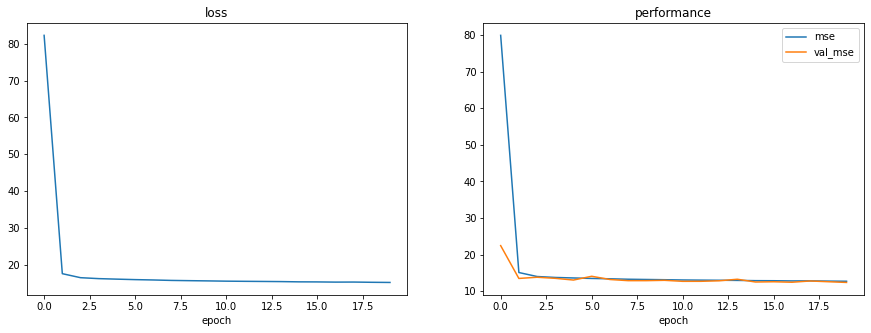

In [18]:
f, ax = plt.subplots(1,2,figsize = [15,5])
ax[0].plot(metrics.history['loss'])
ax[1].plot(metrics.history['mse'])
ax[1].plot(metrics.history['val_mse'])

ax[0].set_title('loss')
ax[1].set_title('performance')
ax[0].set_xlabel('epoch')
ax[1].set_xlabel('epoch')
ax[1].legend(['mse','val_mse'], loc='upper right')
plt.show()

In [41]:
test=pd.read_csv("test.csv",index_col=0)
x_test = np.asarray(prepare_features(test).values).astype('float32')

y_test_predictions=model.predict(x_test)
submission = pd.DataFrame(
    {'key': test.index.values, 'fare_amount': y_test_predictions.squeeze()},
    columns = ['key', 'fare_amount'])
submission.to_csv('submission15.csv', index = False)

In [42]:
import os
os.system('cd ~/studia/kaggle/ && kaggle competitions submit -c gut-dla-2021-competition-1 -f submission15.csv -m "16th try"')

0